In [89]:
%load_ext autoreload
%autoreload 2

import sys
#sys.path.insert(0, './')

In [350]:
import utils
import labels
import beerbubble

In [14]:

import os

import numpy
import pandas

import librosa
import soundfile

from matplotlib import pyplot as plt
import librosa.display

In [127]:
path = './data/Bubbling airlock on pear cider-q2srYoC3FOo.m4a'

path = './data/One hour of apple wine airlock bubbling-by0e-EkAsOE.m4a'
path = './data/ASMR _ Homebrewing Airlock Symphony 🍺🎼 Soothing + Satisfying!-MN0Mg1uyznU.m4a'
#path = './data/Watch an Airlock Bubbling During Mead Fermentation - Entertainment for Brewers-p0jtxp5nWms.m4a'



In [128]:

def load_file(path, sr=16000):
    y, sr = librosa.load(path, offset=0, duration=5*60, sr=sr)
    
    return y
    
audio = load_file(path)

/usr/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [129]:
audio.shape[0] / 16000

300.0

In [130]:
def compute_mfcc(audio, hop_time, sr=16000):

    hop_length = int(sr*hop_time)
    
    mfcc = librosa.feature.mfcc(audio, sr=sr, hop_length=hop_length, n_fft=hop_length*2, n_mfcc=20)
    return mfcc
    
event_length = 0.256/1

ff = compute_mfcc(audio, hop_time=event_length)
ff.shape

(20, 1172)

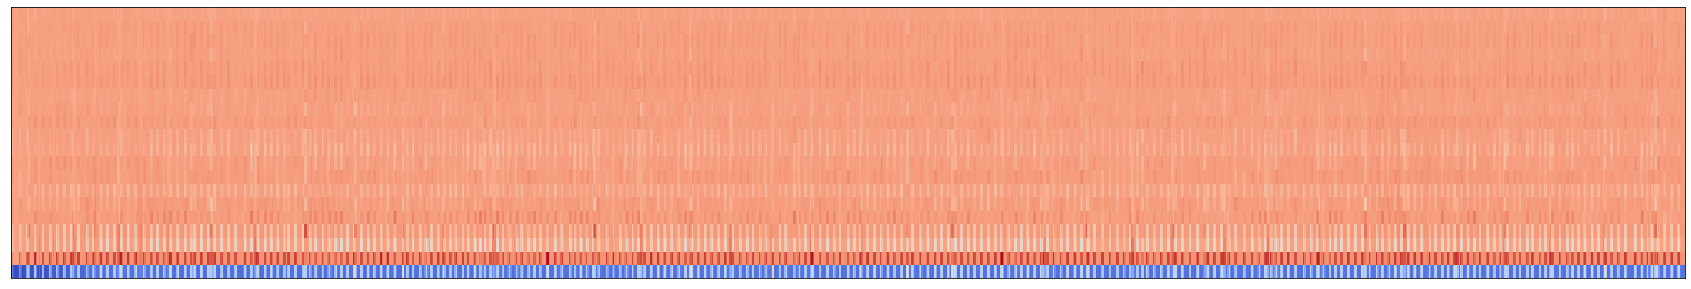

In [131]:
fig, ax = plt.subplots(1, figsize=(30, 5))
librosa.display.specshow(ff, ax=ax, sr=16000, hop_length=event_length*16000)

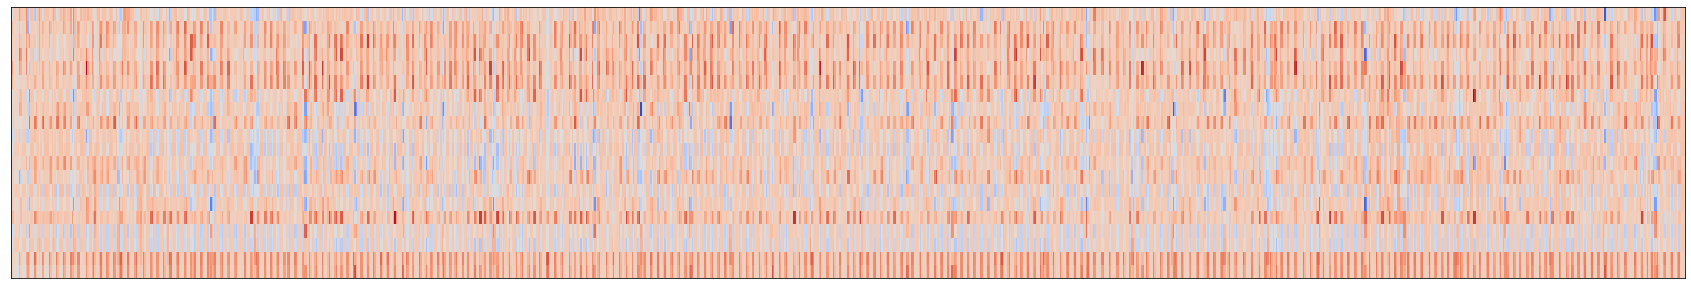

In [132]:
fig, ax = plt.subplots(1, figsize=(30, 5))
m = numpy.median(ff, axis=1, keepdims=True)
s = ff - m
std = numpy.std(s, axis=1, keepdims=True)
s /= std
librosa.display.specshow(s, ax=ax, sr=16000, hop_length=event_length*16000)


In [133]:
dd = numpy.mean(s, axis=0) # numpy.zeros(shape=m.shape[0])
dd.shape

(1172,)

In [134]:

c = librosa.feature.spectral_centroid(audio, sr=16000, hop_length=int(event_length*16000), n_fft=int(event_length*16000*2))[0]
c.shape

(1172,)

In [135]:
t = librosa.core.frames_to_time(numpy.arange(len(c)), hop_length=int(event_length*16000), sr=16000)
t.shape

(1172,)

In [149]:
df.dist.quantile(0.05)

-0.6852136254310608

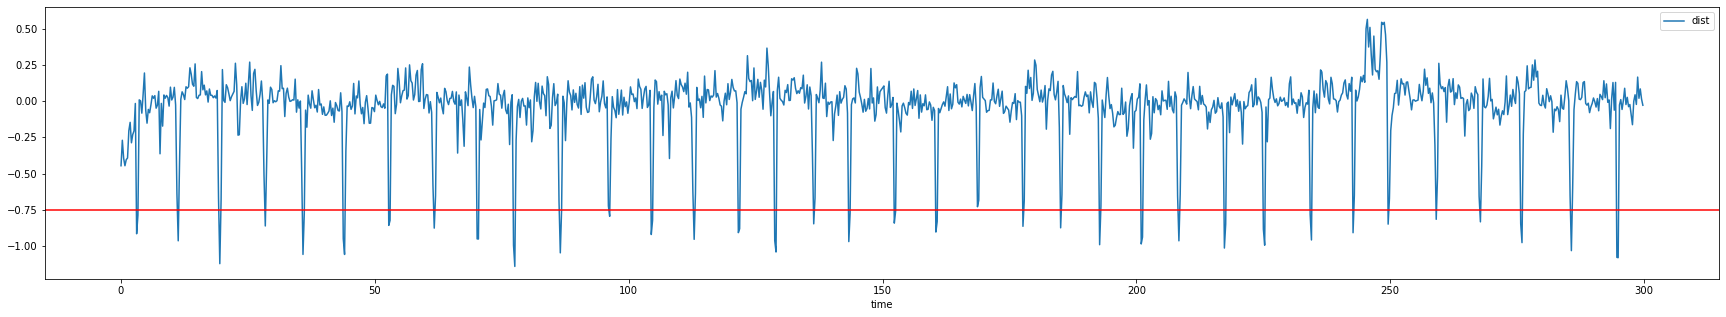

In [145]:
fig, ax = plt.subplots(1, figsize=(30, 5))
df = pandas.DataFrame({
    'centroid': c,
    'dist': dd,
    'time': t,
})
df.plot(ax=ax, y='dist', x='time')
ax.axhline(y=-0.75, color='red')
#df.plot(ax=ax)

<AxesSubplot:xlabel='time'>

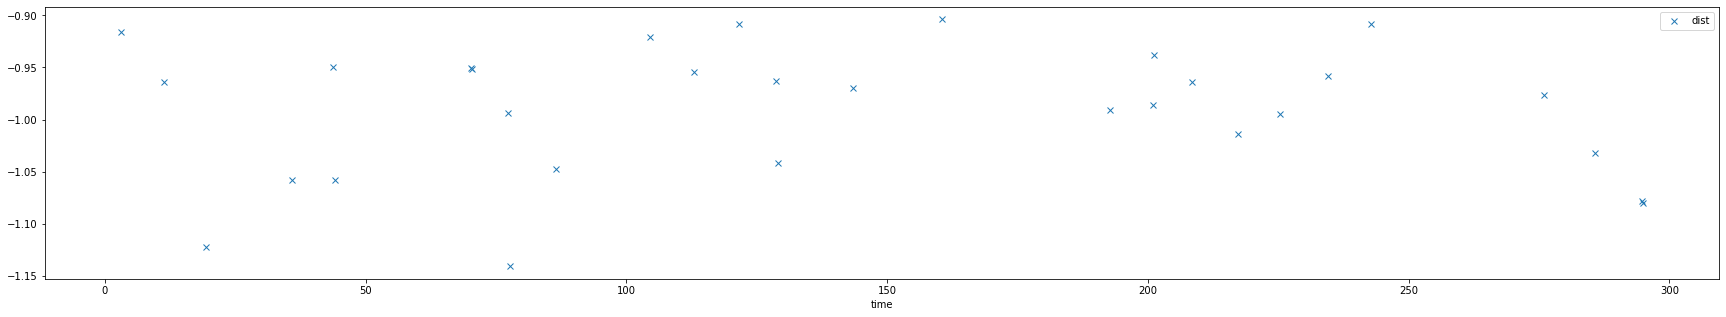

In [137]:
fig, ax = plt.subplots(1, figsize=(30, 5))
df[df['dist'] < -0.9].plot(ax=ax, y='dist', x='time', ls='none', marker='x')

In [140]:
sparse, dense = utils.mark_onoff((-df.set_index('time')['dist']), on_threshold=0.75, off_threshold=0.5)
sparse

3.072      1
3.584      0
11.264     1
11.520     0
19.456     1
          ..
276.224    0
285.696    1
286.208    0
294.656    1
295.168    0
Length: 70, dtype: int64

<AxesSubplot:>

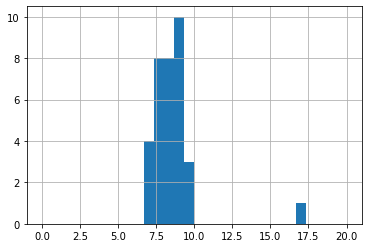

In [142]:
sparse[sparse==1].reset_index()['index'].diff(1).hist(bins=30, range=(0, 20))

In [347]:

lab = utils.join_events(sparse)
lab['annotation'] = 'p'
lab

,start,end,annotation
0,3.072,3.584,p
1,11.264,11.520,p
2,19.456,19.968,p
3,28.416,28.672,p
4,35.840,36.352,p
5,43.776,44.288,p
6,52.736,53.248,p
7,61.696,62.208,p
8,70.144,70.656,p
9,77.312,77.824,p


In [150]:

labels.write(lab, 'labels2.txt')


In [154]:
t.shape

(1172,)

In [156]:
ff.shap

(20, 1172)

In [160]:
dense

0.000      0
0.256      0
0.512      0
0.768      0
1.024      0
          ..
298.752    0
299.008    0
299.264    0
299.520    0
299.776    0
Length: 1172, dtype: int64

In [163]:

feat = pandas.DataFrame(ff.T, index=t)
feat.columns = [ f'MFCC{i}' for i in feat.columns ]
feat['event'] = dense
feat

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,MFCC11,MFCC12,MFCC13,MFCC14,MFCC15,MFCC16,MFCC17,MFCC18,MFCC19,event
0.000,-687.394592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
0.256,-577.623779,50.038441,-88.097977,-60.402542,22.044508,15.759421,-9.095388,9.763987,5.340682,-29.518742,...,-0.186153,-0.961287,-1.643604,18.460224,21.351002,5.643793,6.052406,9.260145,-5.102694,0
0.512,-651.765564,8.690336,-39.401493,-15.760847,18.205084,5.133465,-6.531688,9.385270,7.857866,-12.882486,...,7.150213,4.008849,-3.208511,3.638898,4.233811,-5.536623,-4.251554,3.028214,-0.081872,0
0.768,-687.394592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1.024,-686.918335,0.673183,0.672167,0.670475,0.668114,0.665083,0.661394,0.657053,0.652077,0.646456,...,0.633381,0.625950,0.617941,0.609373,0.600262,0.590633,0.580490,0.569868,0.558782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298.752,-424.784119,133.285416,-104.158676,-72.055832,-1.821957,-5.832156,-24.568821,20.817032,15.227757,-13.783329,...,14.367205,-0.093417,2.125749,26.139990,21.712574,12.025938,22.539663,20.177261,-4.619249,0
299.008,-311.157806,187.682724,-173.994431,-100.759445,17.808716,-27.255470,-54.728710,29.667408,17.170732,-30.898626,...,25.573048,-9.783409,-1.737396,31.132307,11.638620,2.032052,26.802107,17.879644,-8.057225,0
299.264,-574.338562,45.693398,-15.732926,15.756644,15.436896,12.033259,3.675159,27.715290,20.070156,2.448734,...,14.274140,6.555264,2.324006,10.724840,5.794532,-2.687727,0.451370,4.376207,1.129241,0
299.520,-600.801758,32.318676,1.756885,17.857212,5.755670,17.572292,6.933681,11.565662,6.914012,8.354190,...,7.787292,4.537599,4.564642,3.339089,6.155823,4.842264,2.216168,5.603010,2.327099,0


In [168]:

def build_model():
    
    import sklearn.pipeline
    import sklearn.preprocessing
    import sklearn.linear_model
    import sklearn.svm
    import sklearn.neighbors
    from sklearn.compose import make_column_transformer
    from sklearn.compose import make_column_selector
  
    from sklearn.experimental import enable_hist_gradient_boosting

    model = sklearn.pipeline.Pipeline([
        ('scale', sklearn.preprocessing.StandardScaler()),
        ('classifier', sklearn.linear_model.LogisticRegression()),
    ])

    return model

m = build_model()

feature_columns = [ c for c in feat.columns if c.startswith('MFCC') ]
m.fit(feat[feature_columns], feat[['event']])

/home/jon/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', LogisticRegression())])

In [174]:
Y_pred = m.predict(feat[feature_columns])
Y_pred.mean()

0.05716723549488054

In [175]:
import sklearn.metrics
sklearn.metrics.f1_score(feat[['event']], Y_pred)


0.9924812030075187

In [179]:
# TODO: put labeling code into a single function. Run for each input file
# TODO: setup test/val/train. Cross-validation with grouped split

pred = pandas.DataFrame({
  'probability': Y_pred,
}, index=feat.index)
pred

,probability
0.000,0
0.256,0
0.512,0
0.768,0
1.024,0
...,...
298.752,0
299.008,0
299.264,0
299.520,0


array([[<AxesSubplot:title={'center':'index'}>,
        <AxesSubplot:title={'center':'probability'}>]], dtype=object)

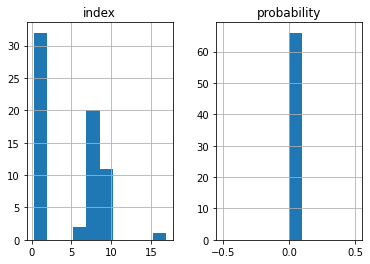

In [184]:
pred[pred.probability == 1].reset_index().diff().hist()

In [348]:
        
pred['class'] = (pred.probability > 0.5).astype(int)
merged = utils.merge_consecutive(pred, col='class')
merged
merged[merged['class'] == 1]

,start,end,class
1,3.072,3.584,1
3,11.264,11.520,1
5,19.456,19.968,1
7,28.416,28.672,1
9,35.840,36.352,1
11,43.776,44.288,1
13,52.736,53.248,1
15,61.696,62.208,1
17,70.144,70.656,1
19,77.312,77.824,1


<AxesSubplot:>

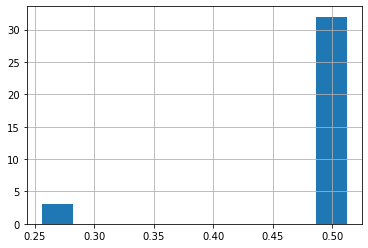

In [213]:
pos = merged[merged['class'] == 1]
(pos['end']-pos['start']).hist()

In [186]:
8/event_length

31.25

ValueError: x is required to have ndim 1 but has ndim 2

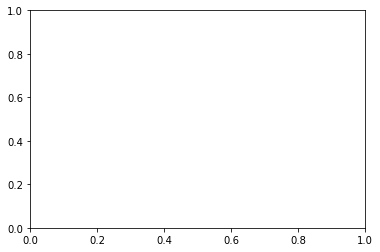

In [349]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(pred, zero=False)

In [ ]:
# TODO: make predictions on whole files


<AxesSubplot:xlabel='time'>

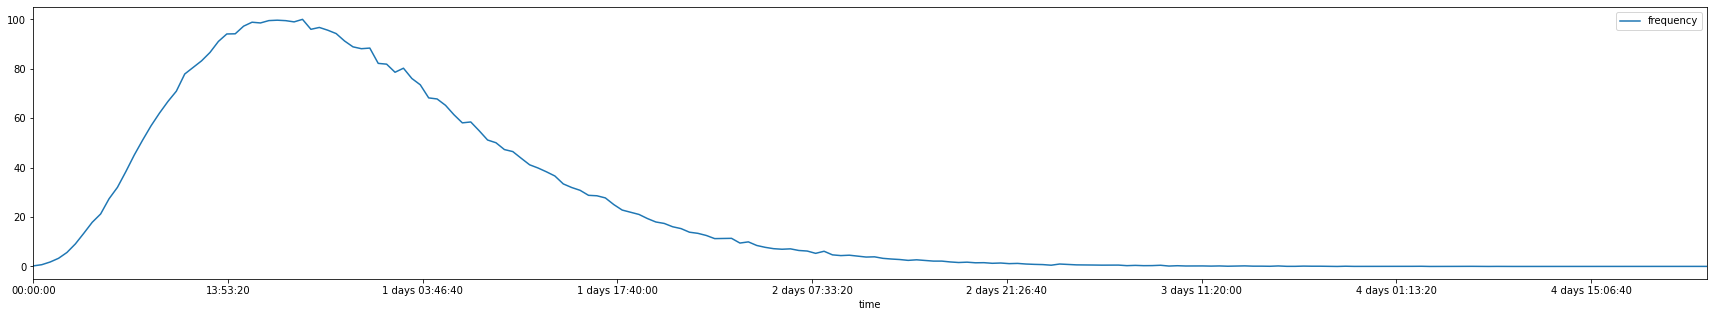

In [352]:

f = beerbubble.synthesize_fermentation_rate()
fig, ax = plt.subplots(1, figsize=(30, 5))
f.plot(ax=ax)


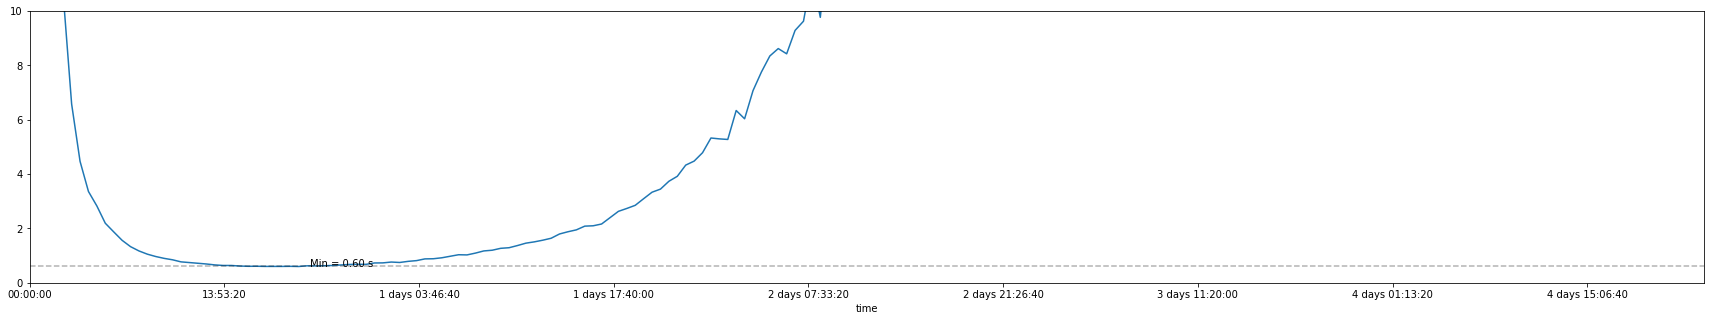

In [353]:

def plot_time_between(df):

    fig, ax = plt.subplots(1, figsize=(30, 5))
    df.plot(ax=ax)
    ax.set(ylim=(0, 10))
    min_time = time_between.min()
    min_pos = pandas.to_timedelta(20, unit='hour')

    ax.axhline(y=min_time, color='black', alpha=0.3, ls='--')
    ax.text(y=min_time, x=min_pos.total_seconds()*1e9, s=f'Min = {min_time:.2f} s')

time_between = (1/f.frequency) * 60
    
plot_time_between(time_between)

In [365]:
    
ee = beerbubble.generate_events(time_between[time_between != numpy.inf])
ee['sec'] = ee['time'].dt.total_seconds()
ee

,time,sec
0,0 days 00:01:25.124226064,85.124226
1,0 days 00:02:50.253800980,170.253801
2,0 days 00:04:15.250416660,255.250417
3,0 days 00:05:40.357046369,340.357046
4,0 days 00:07:05.396618883,425.396619
...,...,...
163795,4 days 20:49:09.783680904,420549.783681
163796,4 days 21:33:06.807546196,423186.807546
163797,4 days 22:17:03.778686445,425823.778686
163798,4 days 23:01:00.862934850,428460.862935


<AxesSubplot:xlabel='time'>

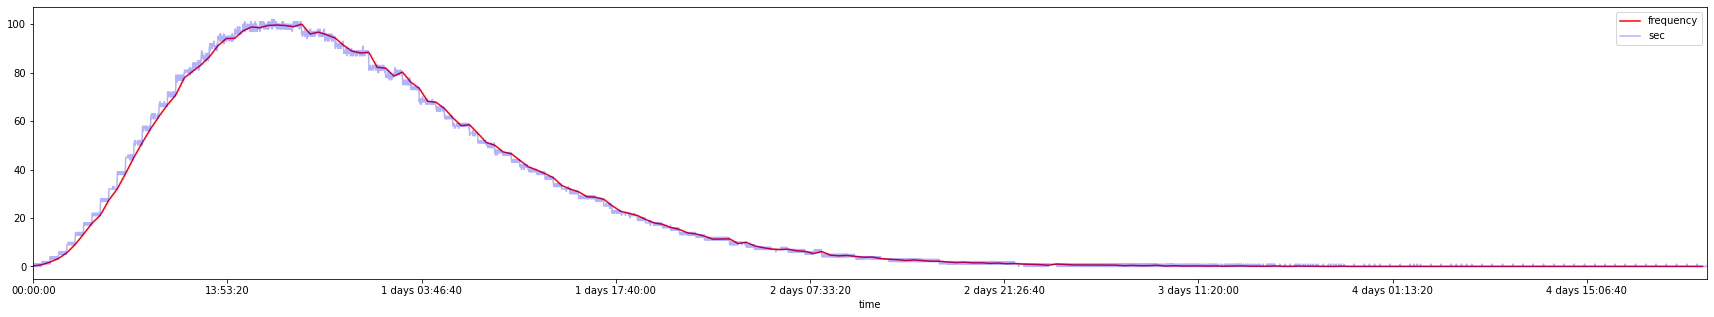

In [366]:
et = ee.set_index('time')
fig, ax = plt.subplots(1, figsize=(30, 5))
f.plot(ax=ax, color='red')
et.resample('1min').count().plot(ax=ax, color='blue', alpha=0.3)